# Ejemplo de uso de tranformer para traducción

Los Transfomers han mostrado un gran potencial para trabajar con problemas que requieren pasar de una secuencia a otra. En particular, su uso en la traducción ha sido extensivo. Aquí mostramos una aplicación a un problema de traducción entre los pares de lenguas español-otomí.

In [1]:
from transformer import transformer_model
import matplotlib.pyplot as plt
from collections import defaultdict
from elotl.corpus import load
from seaborn import heatmap

### Pre-procesamiento de los datos

En primer lugar, debemos obtener los elementos que serán la entrada del modelo de Transformer. Para esto, debemos construir un vocabulario, agregando símbolos especiales: 1) el símbolo de PAD que llena las secuencias para que todas tengan la misma longitud; 2) símbolos de inicio, BOS, y final, EOS, de la secuencia; 3) un símbolo para cuando no se ha observado un elemento del vocabulario en el entrenamiento, OOV.

En este caso, trabajaremos con caracteres como los elementos del vocabulario. Cada caracter se asociará a un índice y además se agregarán a las cadenas de caracteres los índices de los símbolos especiales correspondientes.

In [2]:
#Índices de símbolos especiales
PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2
OOV_IDX = 3

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in list(doc.strip())]
        
#Función para hacer padding
def insert_pad(lista, PAD_IDX=PAD_IDX):    
    l = max([len(cad) for cad in lista])
    pad_lista = []
    for cad in lista:
        pad_cad = cad + [PAD_IDX for i in range(l-len(cad))]
        pad_lista.append(pad_cad)
    return pad_lista

#Funcuón para insertar símbolos a las cadenas
def process_seqs(seqs,BOS_IDX=BOS_IDX,EOS_IDX=EOS_IDX):
    return insert_pad([[BOS_IDX] + cad + [EOS_IDX] for cad in seqs])

Usaremos un sub-corpus, parte del corpus otomí-español Tsunkua. El objetivo es mostrar el funcionamiento del transformer para la traducción. Este corpus contiene algunas frases comúnes en otomí.

In [3]:
#Carcgar el corpus bilingüe
corpus = load('tsunkua')

src = [sent[0].lower() for sent in corpus if sent[3]=='PRONTUARIO EN  OTOMÍ  / ESPAÑOL HÑÄHÑU']
tgt = [sent[1].lower() for sent in corpus if sent[3]=='PRONTUARIO EN  OTOMÍ  / ESPAÑOL HÑÄHÑU']

print(list(zip(src,tgt)))

[('buenos días', "ki hats'i"), ('bienvenidos', 'hogä ehe'), ('muchas gracias', 'ndunthi di jämadi'), ('regresa pronto', "mänt'ä gi pengi"), ('buen provecho', 'nzaki'), ('mi nombre es', 'ma tuhu'), ('pase usted a descansar', 'thogi gi zi tsaya'), ('muchas gracias por su visita', 'ndunthi di jämadi po rá tso̱ni'), ('¡qué disfruten de esta reunión!', "ga ho ra hmunts'i"), ('con permiso, ya me voy', 'ko ri zi nseki, ya dá zi ma'), ('nos vemos pronto', 'ga nzenguahu̱'), ('nos vemos, buen camino', "ga k'athu, hoga 'ñu"), ('buenas tardes', 'ki dee, texki dee'), ('buenos días', 'haxa juä')]


Creamos el vocabulario y las cadenas de índices que tomará el modelo de Trasnformer a partir de las cadenas de textos. Las cadenas estarán compuestas de caracteres. Por tanto, el vocabulario corresponderá a los carateres presentes en ambas lenguas.

In [4]:
#Crear vobulario y cadenas
#Lenguaje fuente
src_voc = vocab()
src_voc['<PAD>'] = PAD_IDX
src_voc['<BOS>'] = BOS_IDX
src_voc['<EOS>'] = EOS_IDX
src_voc['<OOV>'] = OOV_IDX
src_cads = process_seqs(list(text2numba(src,src_voc)))

#Crear vocabulario y cadenas
#Lenguaje objetivo
tgt_voc = vocab()
tgt_voc['<PAD>'] = PAD_IDX
tgt_voc['<BOS>'] = BOS_IDX
tgt_voc['<EOS>'] = EOS_IDX
tgt_cads = process_seqs(list(text2numba(tgt,tgt_voc)))

#Longitudes de los vocabulario
len_src, len_tgt = len(src_voc), len(tgt_voc)

### Creación y entrenamiento del modelo

En primer lugar, definimos el modelo a partir de los hiperparámetros

In [5]:
#Se genera el modelo en base a los hiperparámetros
model = transformer_model(len_src,len_tgt,N=1, d_model=128,d_ff=128,h=1)

Ahora entrenamos el modelo con los datos que hemos pre-procesado:

100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]


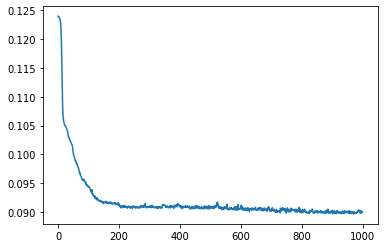

CPU times: user 9min 50s, sys: 866 ms, total: 9min 50s
Wall time: 1min 38s


In [6]:
%%time
#Entrenamiento del modelo
model.train(src_cads,tgt_cads,its=1000,batch_size=2)
#Plot de la pérdida
plt.plot(model.loss)
plt.show()

### Modelo entrenado

Ya que hemos entrenado el modelo, podemos ver cómo funciona. Para esto, definirmos una función que nos proporcionará tensores de entrada para el transformer a partir de cadenas en el lenguaje a traducri. También definimos una función que transforma las salidas (tensoriales) en cadenas del lenguaje traducido.

In [7]:
#Función para convertir cadenas en el formato adecuadi
def get_x_input(sents):
    x_sents = []
    for sent in sents:
        x_sent = []
        for c in list(sent):
            try: 
                idx_c = src_voc[c]
            except: 
                idx_c = src_voc[OOV_IDX]
            x_sent.append(idx_c)
        x_sents.append([BOS_IDX] + x_sent + [EOS_IDX])
        
    return x_sents

#Transformar salidas en palabras
tgt_voc_rev = {k:v for v,k in tgt_voc.items()}
def get_output(sent):
    sent = sent.tolist()[1:]
    return ''.join([tgt_voc_rev[word] for word in sent if word != 0 and word !=2])

Con estas funciones definidas, probamos el transformer en ejemplos específicos del español. El resultado serán cadenas en otomí.

In [9]:
sents = ['buen provecho', 'buenos provechos','bienvenido', 'binvenida', 'nombre', 'mis nombres', 'muchas gracias', 
         'muchas', 'muchas tardes', 'grcias muchs', 'mushas grasias']

for i,sent in enumerate(sents):
    x_input = get_x_input([sent])
    pred = model.predict([x_input],BOS=BOS_IDX, max_len=20)
    y = get_output(pred)
    print('{} --> {}'.format(sent,y))
    #len_y, len_x = len(y), len(x_input[0])
    #att = model.model.decoder.layers[0].self_attn.attn[0].data.reshape(19,19)[:len_y, :len_x]
    #heatmap(att, xticklabels=list(sent), yticklabels=list(y))
    #plt.show()

buen provecho --> nzaki
buenos provechos --> nzaki
bienvenido --> hogä eheheheheheheh
binvenida --> hogä eheheheheheheh
nombre --> ma tuhurá tso̱ni
mis nombres --> ma tuhurá tso̱ni
muchas gracias --> ndunthi di jämadi
muchas --> ndunthi di jämadi
muchas tardes --> ntuhi gi gi zi gi t
grcias muchs --> ndunthi di jämadi
mushas grasias --> ndunthi di jämadi
